In [147]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

In [157]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# Отключение предупреждений
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

class TimeGAN:
    def __init__(self, seq_len=24, hidden_dim=24, num_layers=3, batch_size=128, iterations=10000, learning_rate=0.001):
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.scaler = None
        self.data_columns = None
        
        # Для хранения истории потерь
        self.loss_history = {
            'autoencoder': [],
            'supervisor': [],
            'generator': [],
            'discriminator': [],
            'embedder': []
        }

    def _make_rnn(self, n_layers, hidden_units, output_units, name):
        model = Sequential(name=name)
        for i in range(n_layers):
            model.add(GRU(units=hidden_units, return_sequences=True, name=f'{name}_GRU_{i+1}'))
        model.add(Dense(units=output_units, activation='sigmoid', name=f'{name}_Out'))
        return model

    def _prepare_data(self, data):
        if isinstance(data, pd.DataFrame):
            self.data_columns = data.columns.tolist()
            data_values = data.values
        else:
            self.data_columns = [f'Feature_{i}' for i in range(data.shape[1])]
            data_values = data
        
        # Нормализация данных
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = self.scaler.fit_transform(data_values).astype(np.float32)
        
        # Создание последовательностей
        sequences = []
        for i in range(len(scaled_data) - self.seq_len + 1):
            sequences.append(scaled_data[i:i + self.seq_len])
        
        n_windows = len(sequences)
        real_series = tf.data.Dataset.from_tensor_slices(sequences)
        real_series = real_series.shuffle(buffer_size=n_windows).batch(self.batch_size)
        
        return real_series, n_windows

    def fit(self, data):
        # Подготовка данных
        self.real_series, self.n_windows = self._prepare_data(data)
        self.real_series_iter = iter(self.real_series.repeat())
        self.n_seq = data.shape[1]
        
        # Создание генератора случайных данных
        def make_random_data():
            while True:
                yield np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))
        
        self.random_series = iter(tf.data.Dataset.from_generator(
            make_random_data, output_types=tf.float32)
            .batch(self.batch_size)
            .repeat()
        )
        
        # Инициализация компонентов модели
        self.embedder = self._make_rnn(n_layers=3, hidden_units=self.hidden_dim, 
                                      output_units=self.hidden_dim, name='Embedder')
        self.recovery = self._make_rnn(n_layers=3, hidden_units=self.hidden_dim, 
                                      output_units=self.n_seq, name='Recovery')
        self.generator = self._make_rnn(n_layers=3, hidden_units=self.hidden_dim, 
                                       output_units=self.hidden_dim, name='Generator')
        self.discriminator = self._make_rnn(n_layers=3, hidden_units=self.hidden_dim, 
                                          output_units=1, name='Discriminator')
        self.supervisor = self._make_rnn(n_layers=2, hidden_units=self.hidden_dim, 
                                        output_units=self.hidden_dim, name='Supervisor')
        
        # Автоэнкодер
        X = Input(shape=(self.seq_len, self.n_seq), name='RealData')
        H = self.embedder(X)
        X_tilde = self.recovery(H)
        self.autoencoder = Model(inputs=X, outputs=X_tilde, name='Autoencoder')
        
        # Синтетический генератор
        Z = Input(shape=(self.seq_len, self.n_seq), name='RandomData')
        E_hat = self.generator(Z)
        H_hat = self.supervisor(E_hat)
        X_hat = self.recovery(H_hat)
        self.synthetic_data = Model(inputs=Z, outputs=X_hat, name='SyntheticData')
        
        # Функции потерь
        self.mse = MeanSquaredError()
        self.bce = BinaryCrossentropy()
        
        # Оптимизаторы
        self.autoencoder_opt = Adam(learning_rate=self.learning_rate)
        self.supervisor_opt = Adam(learning_rate=self.learning_rate)
        self.generator_opt = Adam(learning_rate=self.learning_rate)
        self.discriminator_opt = Adam(learning_rate=self.learning_rate)
        self.embedder_opt = Adam(learning_rate=self.learning_rate)
        
        # Обучение
        self._train_autoencoder_init()
        self._train_supervisor()
        self._train_joint()

    def _train_autoencoder_init(self):
        @tf.function
        def train_step(x):
            with tf.GradientTape() as tape:
                x_tilde = self.autoencoder(x)
                loss = 10 * tf.sqrt(self.mse(x, x_tilde))
            grads = tape.gradient(loss, self.autoencoder.trainable_variables)
            self.autoencoder_opt.apply_gradients(zip(grads, self.autoencoder.trainable_variables))
            return loss
        
        print("Обучение автоэнкодера...")
        for step in tqdm(range(self.iterations)):
            X_ = next(self.real_series_iter)
            loss = train_step(X_)
            self.loss_history['autoencoder'].append(loss.numpy())

    def _train_supervisor(self):
        @tf.function
        def train_step(x):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                h_hat_supervised = self.supervisor(h)
                loss = self.mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])
            grads = tape.gradient(loss, self.supervisor.trainable_variables)
            self.supervisor_opt.apply_gradients(zip(grads, self.supervisor.trainable_variables))
            return loss
        
        print("Обучение супервизора...")
        for step in tqdm(range(self.iterations)):
            X_ = next(self.real_series_iter)
            loss = train_step(X_)
            self.loss_history['supervisor'].append(loss.numpy())

    def _train_joint(self):
        # Функции потерь
        def get_generator_moment_loss(y_true, y_pred):
            y_true_mean, y_true_var = tf.nn.moments(y_true, axes=[0])
            y_pred_mean, y_pred_var = tf.nn.moments(y_pred, axes=[0])
            g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
            g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - 
                                       tf.sqrt(y_pred_var + 1e-6)))
            return g_loss_mean + g_loss_var

        # Шаги обучения
        @tf.function
        def train_generator(x, z):
            with tf.GradientTape() as tape:
                # Генерация синтетических данных
                x_hat = self.synthetic_data(z)
                
                # Потери генератора
                y_fake = self.discriminator(x_hat)
                gen_loss_unsupervised = self.bce(tf.ones_like(y_fake), y_fake)
                
                h = self.embedder(x)
                h_hat_supervised = self.supervisor(h)
                gen_loss_supervised = self.mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])
                
                gen_moment_loss = get_generator_moment_loss(x, x_hat)
                
                total_loss = (gen_loss_unsupervised + 
                            100 * tf.sqrt(gen_loss_supervised) + 
                            100 * gen_moment_loss)
            
            trainable_vars = (self.generator.trainable_variables + 
                            self.supervisor.trainable_variables)
            grads = tape.gradient(total_loss, trainable_vars)
            self.generator_opt.apply_gradients(zip(grads, trainable_vars))
            return total_loss

        @tf.function
        def train_discriminator(x, z):
            with tf.GradientTape() as tape:
                # Реальные данные
                y_real = self.discriminator(x)
                real_loss = self.bce(tf.ones_like(y_real), y_real)
                
                # Синтетические данные
                x_hat = self.synthetic_data(z)
                y_fake = self.discriminator(x_hat)
                fake_loss = self.bce(tf.zeros_like(y_fake), y_fake)
                
                total_loss = real_loss + fake_loss
            
            grads = tape.gradient(total_loss, self.discriminator.trainable_variables)
            self.discriminator_opt.apply_gradients(zip(grads, self.discriminator.trainable_variables))
            return total_loss

        # Основной цикл обучения
        print("Совместное обучение...")
        for step in tqdm(range(self.iterations)):
            # Обновление генератора
            X_ = next(self.real_series_iter)
            Z_ = next(self.random_series)
            gen_loss = train_generator(X_, Z_)
            self.loss_history['generator'].append(gen_loss.numpy())
            
            # Обновление дискриминатора
            if step % 2 == 0:
                X_ = next(self.real_series_iter)
                Z_ = next(self.random_series)
                disc_loss = train_discriminator(X_, Z_)
                self.loss_history['discriminator'].append(disc_loss.numpy())

    def generate(self, n_samples=None):
        if n_samples is None:
            n_samples = self.n_windows
        
        # Генерация случайных входных данных
        n_batches = int(np.ceil(n_samples / self.batch_size))
        generated_data = []
        
        for _ in range(n_batches):
            Z_ = np.random.uniform(0, 1, size=(self.batch_size, self.seq_len, self.n_seq))
            d = self.synthetic_data(Z_)
            generated_data.append(d.numpy())
        
        # Объединение и преобразование данных
        generated_data = np.vstack(generated_data)[:n_samples]
        generated_data = generated_data.reshape(-1, self.n_seq)
        
        # Обратное преобразование масштаба
        generated_data = self.scaler.inverse_transform(generated_data)
        
        # Создание DataFrame
        df = pd.DataFrame(generated_data, columns=self.data_columns)
        
        # Добавление мультииндекса (sample, step)
        samples = np.repeat(np.arange(n_samples), self.seq_len)
        steps = np.tile(np.arange(self.seq_len), n_samples)
        df['sample'] = samples
        df['step'] = steps
        df.set_index(['sample', 'step'], inplace=True)
        
        return df

    def plot_losses(self):
        """Визуализация истории потерь во время обучения"""
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.plot(self.loss_history['autoencoder'])
        plt.title('Autoencoder Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.grid(True)
        
        plt.subplot(2, 2, 2)
        plt.plot(self.loss_history['supervisor'])
        plt.title('Supervisor Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.grid(True)
        
        plt.subplot(2, 2, 3)
        plt.plot(self.loss_history['generator'])
        plt.title('Generator Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.grid(True)
        
        plt.subplot(2, 2, 4)
        plt.plot(self.loss_history['discriminator'])
        plt.title('Discriminator Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_losses.png', dpi=300)
        plt.show()

    def visualize_distribution(self, real_data, synthetic_data, n_samples=1000):
        """
        Визуализация распределения реальных и синтетических данных
        с использованием PCA и t-SNE
        """
        # Реальные данные (берем все точки)
        real_samples = real_data.values
        
        # Синтетические данные (разворачиваем все точки)
        synthetic_samples = synthetic_data.reset_index()
        synthetic_samples = synthetic_samples[self.data_columns].values
        
        # Ограничение выборки
        n_samples = min(n_samples, len(real_samples), len(synthetic_samples))
        real_samples = real_samples[:n_samples]
        synthetic_samples = synthetic_samples[:n_samples]
        
        # Объединение данных
        combined_data = np.vstack([real_samples, synthetic_samples])
        labels = ['Real'] * n_samples + ['Synthetic'] * n_samples
        
        # Применение PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(combined_data)
        
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        sns.scatterplot(x=pca_result[:n_samples, 0], y=pca_result[:n_samples, 1], 
                        label='Real', alpha=0.6)
        sns.scatterplot(x=pca_result[n_samples:, 0], y=pca_result[n_samples:, 1], 
                        label='Synthetic', alpha=0.6)
        plt.title('PCA Visualization')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid(True)
        
        # Применение t-SNE
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        tsne_result = tsne.fit_transform(combined_data)
        
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=tsne_result[:n_samples, 0], y=tsne_result[:n_samples, 1], 
                        label='Real', alpha=0.6)
        sns.scatterplot(x=tsne_result[n_samples:, 0], y=tsne_result[n_samples:, 1], 
                        label='Synthetic', alpha=0.6)
        plt.title('t-SNE Visualization')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('distribution_comparison.png', dpi=300)
        plt.show()
        
        # Вычисление и вывод статистики
        pca_real = pca_result[:n_samples]
        pca_synth = pca_result[n_samples:]
        
        print("\nСтатистика PCA компонент:")
        print("Реальные данные:")
        print(f"  PC1: mean={np.mean(pca_real[:, 0]):.4f}, std={np.std(pca_real[:, 0]):.4f}")
        print(f"  PC2: mean={np.mean(pca_real[:, 1]):.4f}, std={np.std(pca_real[:, 1]):.4f}")
        print("\nСинтетические данные:")
        print(f"  PC1: mean={np.mean(pca_synth[:, 0]):.4f}, std={np.std(pca_synth[:, 0]):.4f}")
        print(f"  PC2: mean={np.mean(pca_synth[:, 1]):.4f}, std={np.std(pca_synth[:, 1]):.4f}")

In [161]:
# Генерация длинной последовательности
def generate_long_sequence(timegan, length=100):
    """Генерация последовательности длиннее, чем seq_len"""
    n_chunks = int(np.ceil(length / timegan.seq_len))
    long_sequence = []
    
    for _ in range(n_chunks):
        # Генерируем один чанк
        synth_chunk = timegan.generate(n_samples=1)
        # Извлекаем данные без индексов
        chunk_data = synth_chunk.reset_index(drop=True)
        long_sequence.append(chunk_data)
    
    # Объединяем чанки
    return pd.concat(long_sequence, ignore_index=True).head(length)

In [178]:
data = pd.read_csv('data.csv', index_col=0, parse_dates=True)

In [179]:
data

,RUONIA Индекс,Нефть Brent,Индекс волатильности российского рынка,USDRUB_TOD,EURRUB_TOD,Индекс МосБиржи RU000A0JP7K5,Нефть WTI,Gold Price Index
Дата,,,,,,,,
2015-10-01,1.440350,47.69,37.16,65.2030,73.0500,1626.97,44.74,77.30
2015-10-02,1.440790,48.13,38.47,66.3700,74.0600,1612.56,45.54,75.91
2015-10-05,1.442140,49.25,38.16,64.7960,73.0650,1652.47,46.26,76.43
2015-10-06,1.442570,51.92,35.67,64.0300,72.9900,1670.69,48.53,77.99
2015-10-07,1.442980,51.33,35.77,61.9200,69.9610,1679.49,47.81,77.53
...,...,...,...,...,...,...,...,...
2024-06-05,3.018590,78.41,24.55,88.7750,96.0025,3212.24,74.07,217.37
2024-06-06,3.019910,79.87,25.23,88.9750,96.6650,3192.38,75.55,216.25
2024-06-07,3.021240,79.62,22.27,89.1200,96.4000,3233.22,75.53,217.60


In [180]:
import yfinance as yf
# tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA']
# data = yf.download(tickers, start='2010-01-01', end='2020-01-01')['Close']


data = data.pct_change()
data = data.dropna()

Обучение автоэнкодера...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 133.05it/s]


Обучение супервизора...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 221.96it/s]


Совместное обучение...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:12<00:00, 19.80it/s]


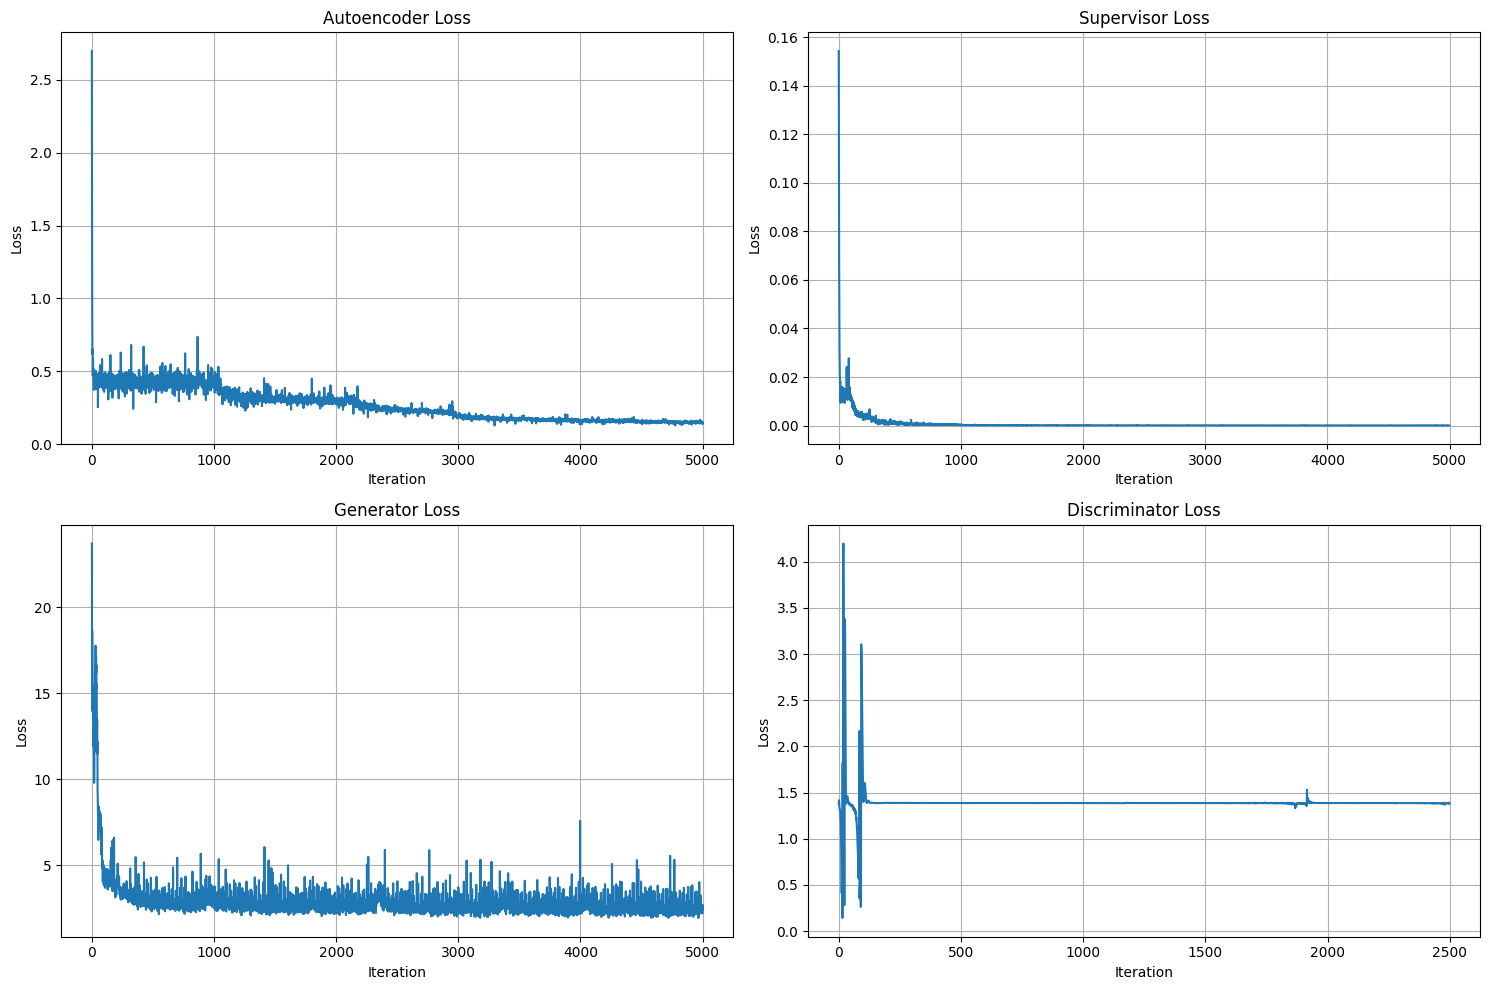

In [181]:
# Обучение TimeGAN
model = TimeGAN(seq_len=24, hidden_dim=24, num_layers=3, batch_size=128, iterations=5000, learning_rate=0.01)
model.fit(data)
model.plot_losses()

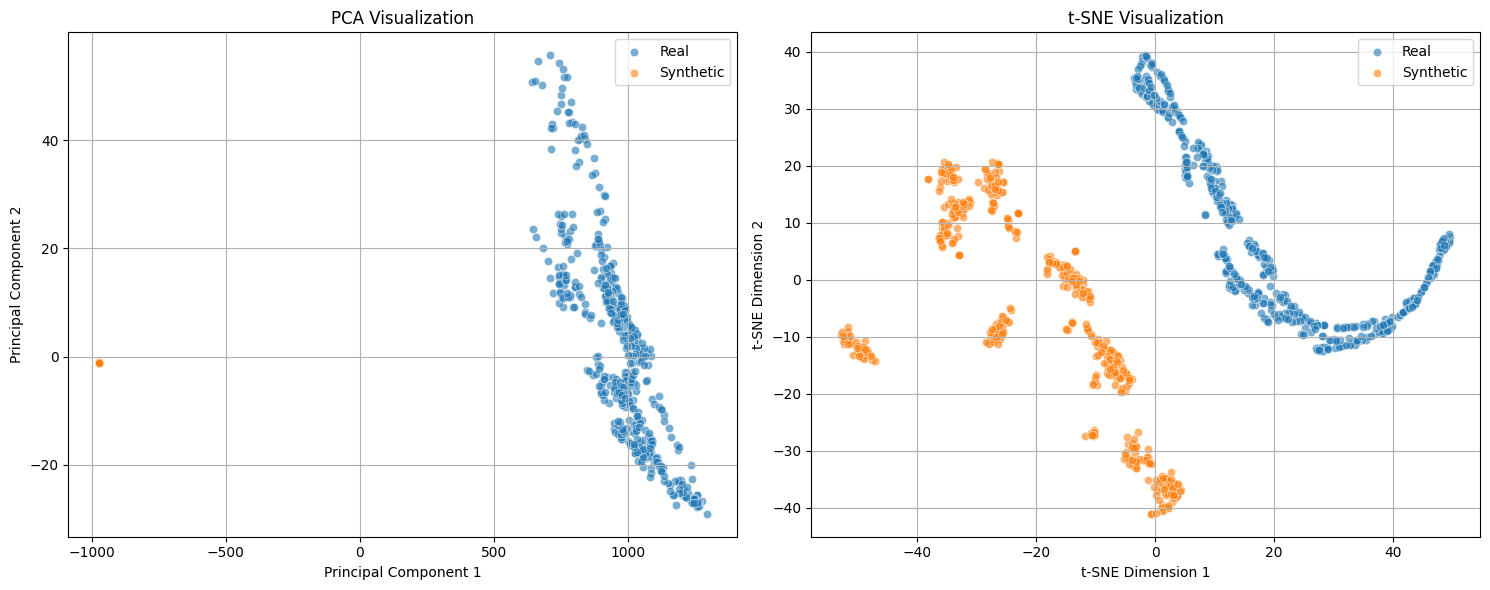


Статистика PCA компонент:
Реальные данные:
  PC1: mean=974.4614, std=135.7969
  PC2: mean=1.1009, std=18.7106

Синтетические данные:
  PC1: mean=-974.4614, std=0.0127
  PC2: mean=-1.1009, std=0.0331


In [235]:
long_synthetic = generate_long_sequence(model, length=500)
model.visualize_distribution(data, long_synthetic)

In [164]:
# tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA']
# data = yf.download(tickers, start='2010-01-01', end='2020-01-01')['Close']

[*********************100%***********************]  6 of 6 completed


In [236]:
data = pd.read_csv('data.csv', index_col=0, parse_dates=True)

In [237]:
data = data.dropna()

In [238]:
last_price = data.iloc[-1]

In [239]:
generated_data = []
for percent_change in long_synthetic.values:
    generated_data.append(pd.DataFrame(last_price).T)
    last_price = last_price * (1 + percent_change)
generated_data.append(pd.DataFrame(last_price).T)

In [240]:
generated_data = pd.concat(generated_data)

In [241]:
generated_data = generated_data.reset_index(drop=True)

In [242]:
generated_data

,RUONIA Индекс,Нефть Brent,Индекс волатильности российского рынка,USDRUB_TOD,EURRUB_TOD,Индекс МосБиржи RU000A0JP7K5,Нефть WTI,Gold Price Index
0,3.026512,81.920000,25.170000,89.130000,95.450000,3171.100000,77.900000,215.440000
1,3.027224,83.635322,23.786807,89.122169,95.739367,3199.458648,79.828693,214.838645
2,3.027990,84.135732,26.034174,90.256110,96.647239,3166.799493,80.445988,214.479352
3,3.031203,87.215099,26.986220,88.501914,94.743330,3157.090264,83.345171,217.112772
4,3.032077,86.420806,26.885615,88.368068,94.154491,3147.052326,82.188776,215.550957
...,...,...,...,...,...,...,...,...
496,3.620149,45.096307,3.453267,74.692500,99.146818,3625.449850,29.930844,252.590147
497,3.621121,43.817883,3.420620,74.507412,99.601302,3614.660294,29.182381,251.369293
498,3.622053,43.474527,3.126020,73.930759,99.207557,3666.823456,29.112989,253.800668
499,3.622992,44.268336,3.444170,75.319187,100.926675,3639.447541,29.657218,252.131781


In [243]:
def plot_column(column_name):
    plt.plot(generated_data[column_name])
    plt.title(column_name)
    plt.show()

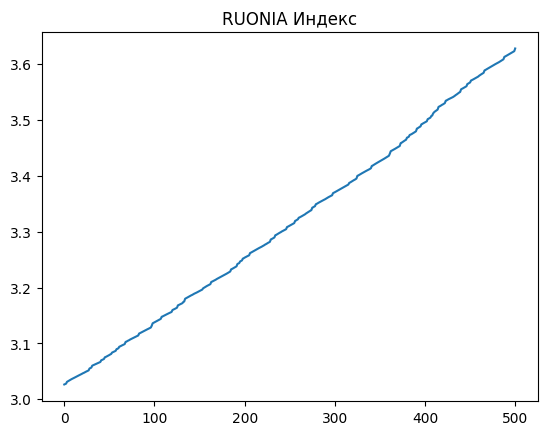

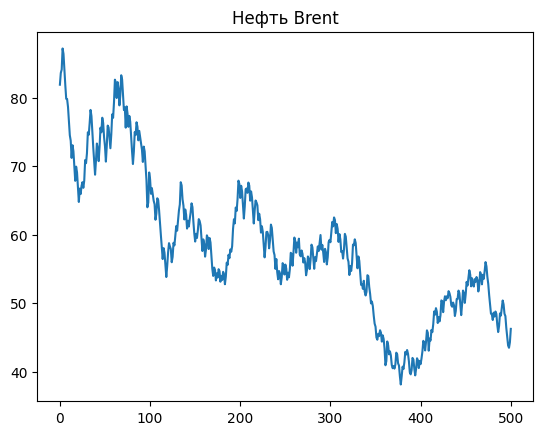

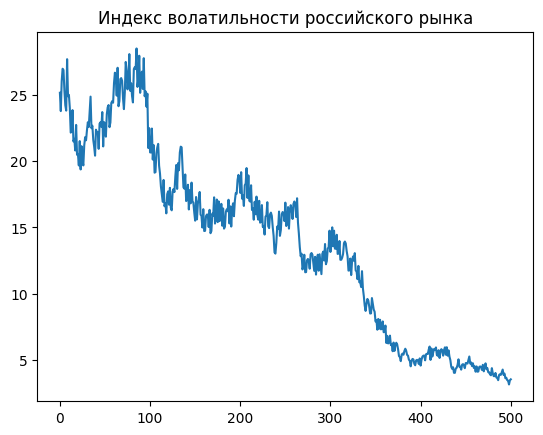

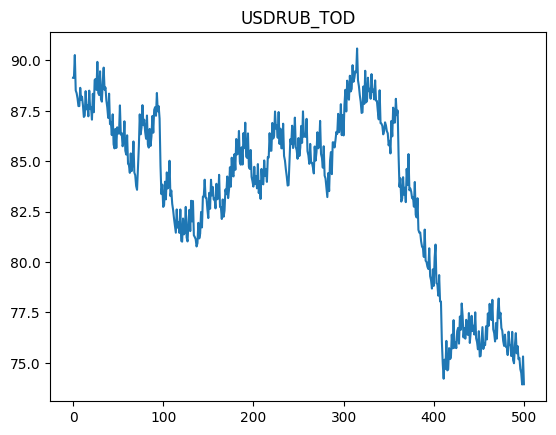

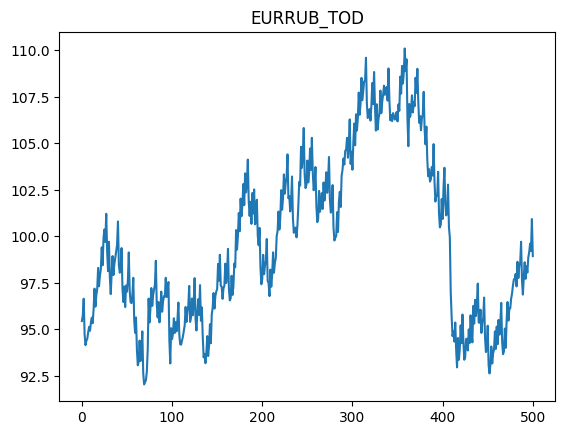

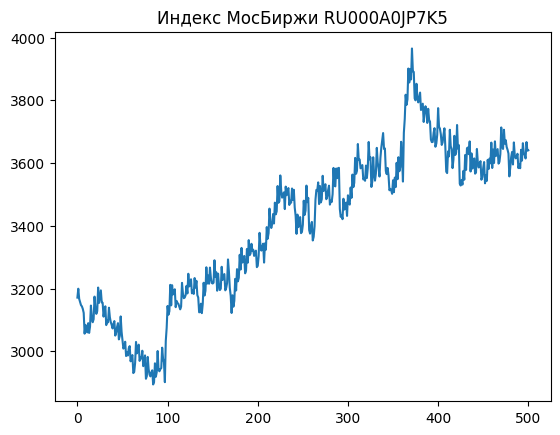

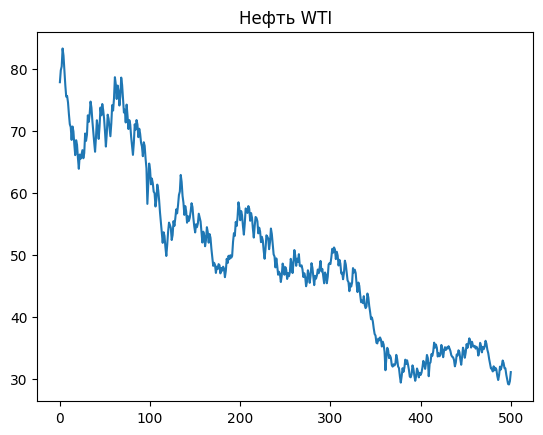

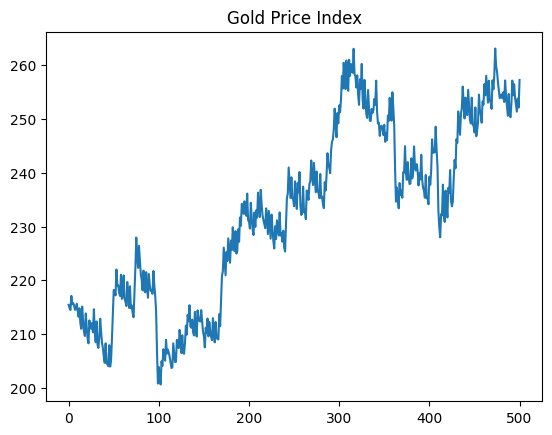

In [244]:
for col in generated_data.columns:
    plot_column(col)